This notebok is Part 2 (Modeling). Please see Part 1 (EDA and Data Preparation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time  

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [2]:
'''
In the previous notebook, I created two dataframes. One which was treated for multicollinearity, 
and another that was treated for outliers--to be used in models that are sensitive for othe or the other.
I also transformed two of the features using Log transformaiton.
Let us export the dataframes, starting from the one without multi-collinearity. 
'''
# Export dataframe without Multicollinearity
df_no_mc = pd.read_csv('df_no_mc.csv')
df_no_mc.sample(5)

,job,marital,education,default,month,previous,poutcome,emp.var.rate,y,camp_log,dur_log
14709,admin.,single,high.school,no,jul,0,nonexistent,1.4,no,1.609438,5.393628
13143,services,single,professional.course,no,jul,0,nonexistent,1.4,no,0.000000,5.220356
31162,admin.,married,unknown,no,may,0,nonexistent,-1.8,no,0.000000,5.337538
1275,entrepreneur,married,basic.6y,no,may,0,nonexistent,1.1,no,0.000000,5.433722
6670,services,divorced,professional.course,unknown,may,0,nonexistent,1.1,no,0.693147,5.214936


In [3]:
# Let us scale the numerical columns:
# Select the numerical columns to be scaled
numerical_cols = ['emp.var.rate', 'camp_log', 'dur_log']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the selected columns
df_no_mc[numerical_cols] = scaler.fit_transform(df_no_mc[numerical_cols])

In [4]:
df_no_mc.sample(5)

,job,marital,education,default,month,previous,poutcome,emp.var.rate,y,camp_log,dur_log
26486,entrepreneur,married,high.school,no,nov,0,nonexistent,-0.116196,no,-0.938748,-0.164419
9689,admin.,married,university.degree,no,jun,0,nonexistent,0.838783,no,0.062788,-0.150151
19769,self-employed,married,basic.9y,no,aug,0,nonexistent,0.838783,no,0.062788,-0.634005
18980,technician,divorced,professional.course,no,aug,0,nonexistent,0.838783,no,-0.938748,-0.246462
948,technician,divorced,unknown,no,may,0,nonexistent,0.647788,no,-0.938748,0.975054


In [5]:
#Let us do one-hot including for the "df_no_mc" dataframe

# Identify categorical columns (columns with data type 'object')
categorical_columns = df_no_mc.select_dtypes(include=['object']).columns

# Apply one-hot encoding to the categorical columns, dropping the first column
df_encoded = pd.get_dummies(df_no_mc, columns=categorical_columns, drop_first=True)

df_encoded.sample(5)

,previous,emp.var.rate,camp_log,dur_log,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,y_yes
36884,0,-1.898823,0.062788,1.084052,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
4628,0,0.647788,-0.938748,-0.679369,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
36234,0,-1.898823,-0.938748,-0.488776,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
24035,0,-0.116196,-0.938748,-0.302124,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
36626,0,-1.898823,0.062788,-0.254239,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


In [6]:
df_encoded.describe()

,previous,emp.var.rate,camp_log,dur_log,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,y_yes
count,41087.000000,4.108700e+04,4.108700e+04,4.108700e+04,41087.000000,41087.000000,41087.000000,41087.000000,41087.000000,41087.000000,...,41087.000000,41087.000000,41087.000000,41087.000000,41087.000000,41087.000000,41087.000000,41087.000000,41087.000000,41087.000000
mean,0.172780,-2.019880e-13,-1.471939e-14,-2.982919e-16,0.224694,0.035315,0.025702,0.071093,0.041668,0.034390,...,0.174264,0.129141,0.013216,0.334242,0.099545,0.017402,0.013873,0.863606,0.033271,0.112542
std,0.494836,1.000012e+00,1.000012e+00,1.000012e+00,0.417386,0.184578,0.158245,0.256983,0.199831,0.182232,...,0.379341,0.335360,0.114199,0.471731,0.299396,0.130766,0.116965,0.343210,0.179345,0.316036
min,0.000000,-2.217149e+00,-9.387482e-01,-5.561976e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-1.198505e+00,-9.387482e-01,-5.798624e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,6.477875e-01,6.278825e-02,3.198132e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,8.387833e-01,6.486495e-01,6.484035e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,7.000000,8.387833e-01,4.877530e+00,3.595102e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
#Just in case, let us check for NaN and infinite values:

# Check for NaN values
nan_values = df_encoded.isna().sum()

# Check for infinite values
infinite_values = df_encoded.applymap(lambda x: np.isinf(x) if isinstance(x, (int, float)) else False).sum()

# Display columns with NaN and infinite values
columns_with_nan = nan_values[nan_values > 0].index
columns_with_infinite = infinite_values[infinite_values > 0].index

print("Columns with NaN values:", columns_with_nan)
print("Columns with infinite values:", columns_with_infinite)

Columns with NaN values: Index([], dtype='object')
Columns with infinite values: Index([], dtype='object')


In [8]:
#Let us first do the test / train split for the df_no_mc. We will use it for Logistic regression
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop('y_yes', axis = 1), 
                                                    df_encoded['y_yes'],
                                                   random_state=1)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

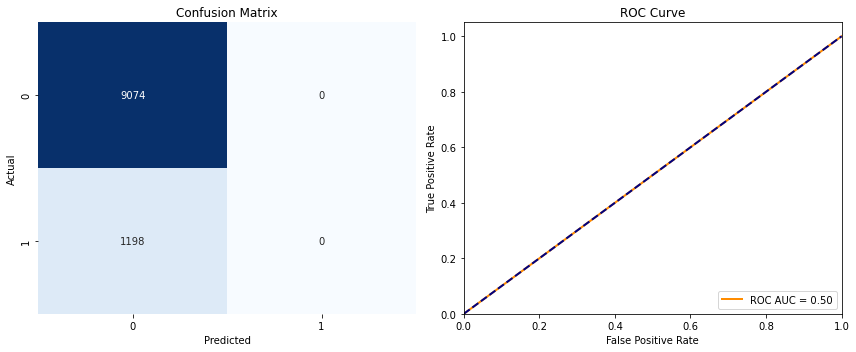

In [9]:
# Create a dummy classifier that predicts the majority class (0)
dummy_classifier = DummyClassifier(strategy='most_frequent')

# Train the dummy classifier on the training data
dummy_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dummy_classifier.predict(X_test)

# Compute the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Compute ROC curve and ROC AUC
y_prob = dummy_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots for confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [10]:
#Let us get the classification report for our dummy classifier:
# Generate a classification report 
classification_rep = classification_report(y_test, y_pred, zero_division=1)

# Print the classification report without the warning
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      9074
           1       1.00      0.00      0.00      1198

    accuracy                           0.88     10272
   macro avg       0.94      0.50      0.47     10272
weighted avg       0.90      0.88      0.83     10272



### Observation:
- As expected, the dummy classifier classifies every record as "0" (the majority class)
- Because 88% of the records in the Test set are 0s, he Accuracy looks quite good (0.88)
- However, the metric of interest (Recall for Class 1) is very bad (0)
- ROC AUC is 0.5, which is to be expected from a dummy classifier.

### Problem 8: A Simple Model - Logistic Regression

Use Logistic Regression to build a basic model on your data.  

In [11]:
# Start measuring time
start_time = time.time()

# Create a Logistic Regression model
logistic_model = LogisticRegression(random_state=1, max_iter=1000)

# Train the model on the training data
logistic_model.fit(X_train, y_train)

# Stop measuring time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Print Training / Search time and Best Hyperparameters
print("Training Time:", training_time, "seconds")


Training Time: 0.1642918586730957 seconds


### Problem 9: Score the Simple Model - Logistic Regression

What is the accuracy of your model?

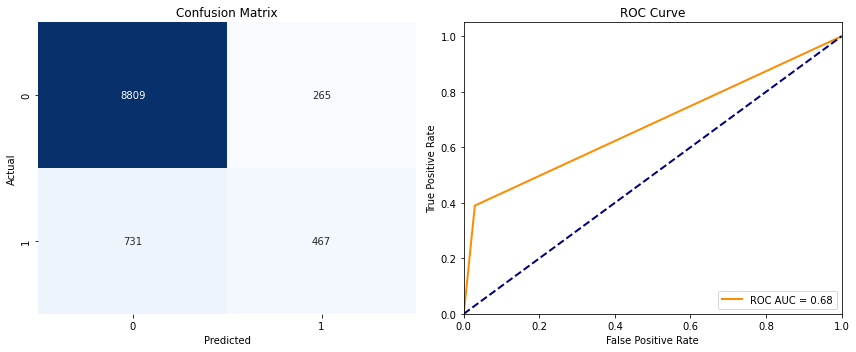

In [12]:
# Now let us see how it performs

# Make predictions on the test data
y_pred = logistic_model.predict(X_test)

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)

# Compute ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots for confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [13]:
# Generate a classification report 
classification_rep = classification_report(y_test, y_pred, zero_division=1)

# Print the classification report without the warning
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      9074
           1       0.64      0.39      0.48      1198

    accuracy                           0.90     10272
   macro avg       0.78      0.68      0.72     10272
weighted avg       0.89      0.90      0.89     10272



# Observations:
- The simple logistic regression produced better accuracy (0.90)
- The Class 1 Recall (our main metric) is better too (0.39)
- ROC AUC is also better than the Dumb Classifier: 0.68

## Optimized Logistic Regression

In [14]:
# Since Class 1 Recall is the key metric, let us define a function for it
def custom_class_1_recall(y_true, y_pred):
    recall = recall_score(y_true, y_pred, pos_label=1)
    return recall


Leet us optimize Logistic Regression model using GridSearch CV. 

I will select several Hyperparameters and will time the search. Hope it won't take too long.

In [15]:
# Start measuring time
start_time = time.time()

# Define the hyperparameters and their possible values
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [5000, 10000]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(random_state=1), 
                           param_grid,
                           cv=5,
                           verbose=2,
                           n_jobs=-1,
                          scoring=make_scorer(custom_class_1_recall)
                          )

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Stop measuring time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Retrieve the best hyperparameters and the best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print Training / Search time and Best Hyperparameters
print("Training Time:", training_time, "seconds")
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Training Time: 14.491924047470093 seconds
Best Hyperparameters: {'C': 1, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'saga'}


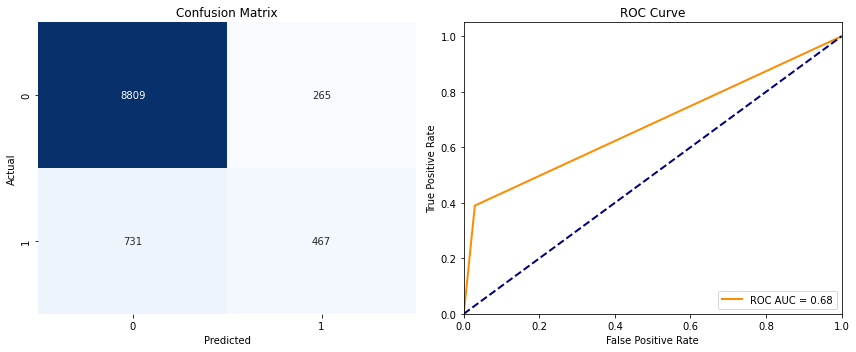

In [16]:
# Now let us see how it performs

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)

# Compute ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots for confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [17]:
# Generate a classification report 
classification_rep = classification_report(y_test, y_pred, zero_division=1)

# Print the classification report without the warning
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      9074
           1       0.64      0.39      0.48      1198

    accuracy                           0.90     10272
   macro avg       0.78      0.68      0.72     10272
weighted avg       0.89      0.90      0.89     10272



### Observation:
Grid Search CV failed to improve the performance of Logistic Regression

Let us try other models.

## Basic KNN

KNN can be sensitive to outliers. Therefore, we will use the data set where we treated outliers

In [18]:
# Export dataframe without Multicollinearity
df_no_outliers = pd.read_csv('df_no_mc.csv')
df_no_outliers.sample(5)

,job,marital,education,default,month,previous,poutcome,emp.var.rate,y,camp_log,dur_log
29200,technician,single,university.degree,no,apr,0,nonexistent,-1.8,no,0.693147,4.744932
34448,technician,single,professional.course,unknown,may,0,nonexistent,-1.8,no,0.693147,5.505332
40469,admin.,married,university.degree,no,sep,0,nonexistent,-1.1,no,0.693147,6.538140
40116,housemaid,married,basic.4y,no,jul,0,nonexistent,-1.7,yes,0.693147,6.915723
33442,blue-collar,married,unknown,no,may,0,nonexistent,-1.8,no,0.693147,4.454347


In [19]:
# KNN also requires that numerical data is scaled. Let us scale the numerical columns using Standard Scaler
# Select the numerical columns to be scaled
numerical_cols = ['emp.var.rate', 'camp_log', 'dur_log']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the selected columns
df_no_outliers[numerical_cols] = scaler.fit_transform(df_no_mc[numerical_cols])
df_no_outliers.sample(5)

,job,marital,education,default,month,previous,poutcome,emp.var.rate,y,camp_log,dur_log
1517,services,married,basic.9y,no,may,0,nonexistent,0.647788,no,0.062788,0.571426
12710,services,married,high.school,no,jul,0,nonexistent,0.838783,no,-0.938748,-0.238740
21677,admin.,married,university.degree,unknown,aug,0,nonexistent,0.838783,no,1.064325,1.344963
24602,management,divorced,university.degree,no,nov,0,nonexistent,-0.116196,no,0.062788,0.208246
29427,admin.,single,university.degree,no,apr,1,failure,-1.198505,no,-0.938748,0.526999


In [20]:
# Identify categorical columns (columns with data type 'object')
categorical_columns = df_no_outliers.select_dtypes(include=['object']).columns

# Apply one-hot encoding to the categorical columns, dropping the first column
df_encoded = pd.get_dummies(df_no_outliers, columns=categorical_columns, drop_first=True)

df_encoded.sample(5)

,previous,emp.var.rate,camp_log,dur_log,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,y_yes
9833,0,0.838783,-0.938748,1.504173,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
30174,0,-1.198505,-0.938748,-0.352236,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
9910,0,0.838783,-0.938748,-1.169571,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
26626,0,-0.116196,0.062788,-0.911091,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
16744,0,0.838783,-0.938748,-0.985412,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [21]:
#Let us do a Train-Test split:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop('y_yes', axis = 1), 
                                                    df_encoded['y_yes'],
                                                   random_state=1)

In [22]:
# instantiate the model (using the default parameters)
KNN = KNeighborsClassifier()

# Start the timer
start_time = time.time()

# fit the model with data
KNN.fit(X_train, y_train)

# End the timer
end_time = time.time()

# Calculate the difference
elapsed_time = end_time - start_time

print('Elapsed Time:', elapsed_time)

y_pred = KNN.predict(X_test)
KNN_score_train = KNN.score(X_train, y_train)
KNN_score_test = KNN.score(X_test, y_test)
print('KNN Score Train:', KNN_score_train)
print('KNN Score Test:', KNN_score_test)

Elapsed Time: 0.005983829498291016
KNN Score Train: 0.9290605224728217
KNN Score Test: 0.8970989096573209


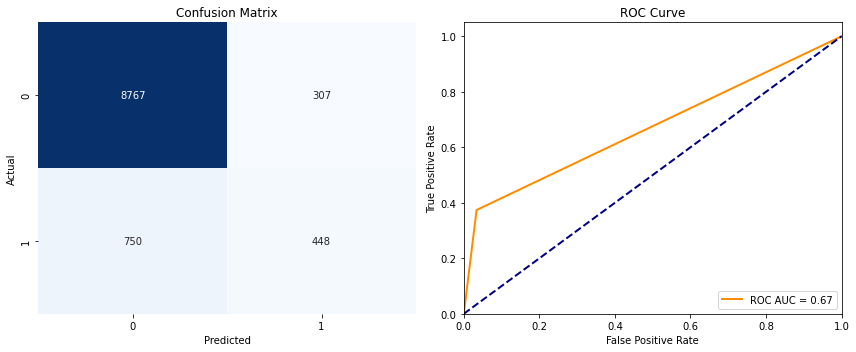

In [23]:
# Now let us see how basic KNN performs

# Make predictions using the best model
y_pred = KNN.predict(X_test)

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)

# Compute ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots for confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [24]:
# Generate a classification report 
classification_rep = classification_report(y_test, y_pred, zero_division=1)

# Print the classification report without the warning
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      9074
           1       0.59      0.37      0.46      1198

    accuracy                           0.90     10272
   macro avg       0.76      0.67      0.70     10272
weighted avg       0.88      0.90      0.89     10272



### Observations:

The basic KNN model did slightoly worse than Logistic Regression
- THe most important metric (Class 1 Recall) was 0.37
- ROC AUC was 0.67

Let us see if we can optimized it

## Optimized KNN

In [25]:

# Define the hyperparameters and their possible values
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13], 
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Start the timer
start_time = time.time()

# Create a GridSearchCV object
grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring=make_scorer(custom_class_1_recall)
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

# Print the best parameters
print("Best hyperparameters:", grid_search.best_params_)

# Refit the KNN model using the best hyperparameters
best_knn = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Elapsed Time: 223.108891248703
Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


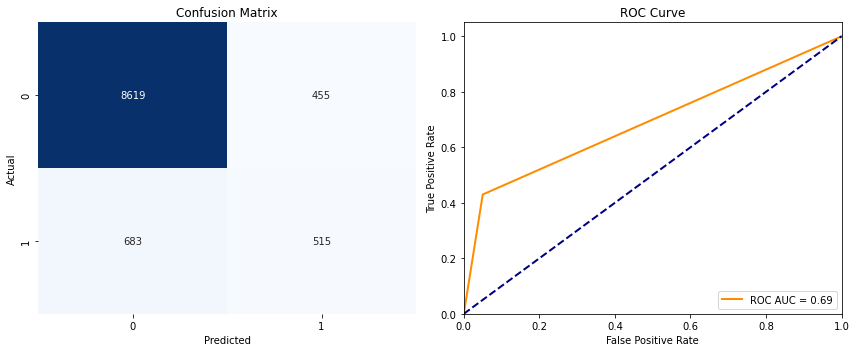

In [26]:
# Now let us see how best KNN performs

# Make predictions using the best model
y_pred = best_knn.predict(X_test)

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)

# Compute ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots for confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [27]:
# Generate a classification report 
classification_rep = classification_report(y_test, y_pred, zero_division=1)

# Print the classification report without the warning
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      9074
           1       0.53      0.43      0.48      1198

    accuracy                           0.89     10272
   macro avg       0.73      0.69      0.71     10272
weighted avg       0.88      0.89      0.88     10272



### Observation

Optimizing KNN helped improving performance slightly bet
- Class 1 Recall increased to 0.43
- Overall accuracy is 0.89
- ROC AUC went up to 0.69

## Basic Decision Tree

In [28]:
# Start the timer
start_time = time.time()

# Create a DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dt_classifier.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

Elapsed Time: 0.12523174285888672


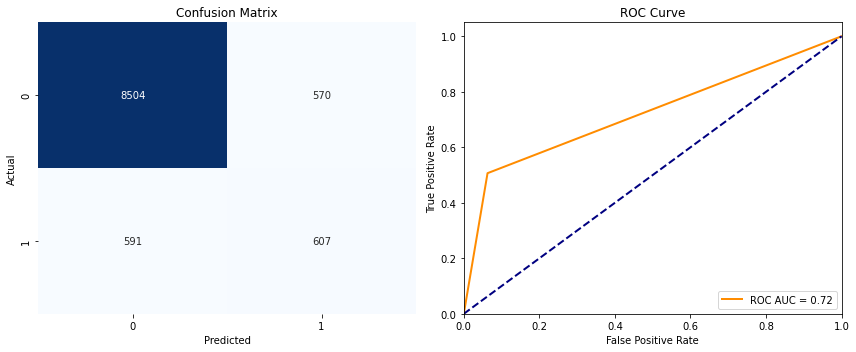

In [29]:
# Now let us see how basic DT performs

# Make predictions on the test data
y_pred = dt_classifier.predict(X_test)

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)

# Compute ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots for confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [30]:
# Generate a classification report 
classification_rep = classification_report(y_test, y_pred, zero_division=1)

# Print the classification report without the warning
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      9074
           1       0.52      0.51      0.51      1198

    accuracy                           0.89     10272
   macro avg       0.73      0.72      0.72     10272
weighted avg       0.89      0.89      0.89     10272



### Observation

- Basic Decision Tree did quite well in terms of Class 1 Recall (0.50)
- The overall Accuracy was 0.89
- ROC AUC was 0.72

Let us optimize Decision Tree

In [31]:

# Start the timer
start_time = time.time()

# Define the hyperparameters and their possible values
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Create a GridSearchCV object with custom scoring
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring=make_scorer(custom_class_1_recall)
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

# Get the best estimator (best model)
best_dt_classifier = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 1190 candidates, totalling 5950 fits
Elapsed Time: 123.29587173461914
Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


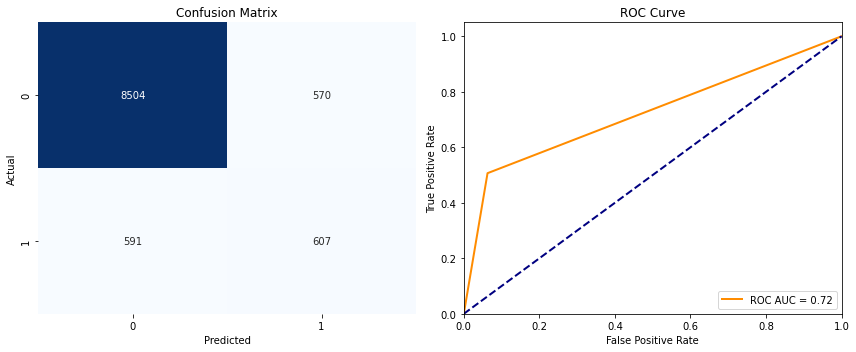

In [32]:
# Now let us see how Optimized DT performs

# Make predictions on the test data
y_pred = best_dt_classifier.predict(X_test)

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)

# Compute ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots for confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [33]:
# Generate a classification report 
classification_rep = classification_report(y_test, y_pred, zero_division=1)

# Print the classification report without the warning
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      9074
           1       0.52      0.51      0.51      1198

    accuracy                           0.89     10272
   macro avg       0.73      0.72      0.72     10272
weighted avg       0.89      0.89      0.89     10272



## Observations:
- Optimized Decision Tree did not produce significant improvements in key metric

## Basic SVM

In [34]:
# Start the timer
start_time = time.time()

svc = SVC().fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time

# Calculate the difference
print('Elapsed Time:', elapsed_time)


Elapsed Time: 12.626311302185059


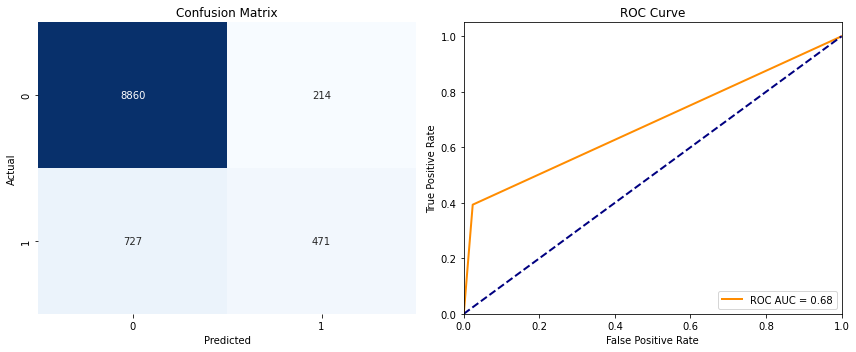

In [35]:
# Now let us see how Basic SVM did 

# Make predictions on the test data
y_pred = svc.predict(X_test)

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)

# Compute ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots for confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [36]:
# Generate a classification report 
classification_rep = classification_report(y_test, y_pred, zero_division=1)

# Print the classification report without the warning
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      9074
           1       0.69      0.39      0.50      1198

    accuracy                           0.91     10272
   macro avg       0.81      0.68      0.72     10272
weighted avg       0.90      0.91      0.90     10272



### Observation:
Basic SVM did not do as well as some other models:
- Class 1 Recall of 0.39
- Overall Accuracy of 0.91
- ROC AUC of 0.68

## Optimized SVM

In [37]:
# Start the timer
start_time = time.time()

# Define the hyperparameters and their possible values
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  
    'gamma': ['scale', 'auto', 0.1, 1],  
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
    SVC(random_state=1),  
    param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring=make_scorer(custom_class_1_recall)
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time

# Calculate the difference
print('Elapsed Time:', elapsed_time)

# Get the best estimator (best model)
best_svc = grid_search.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Elapsed Time: 14838.475667476654


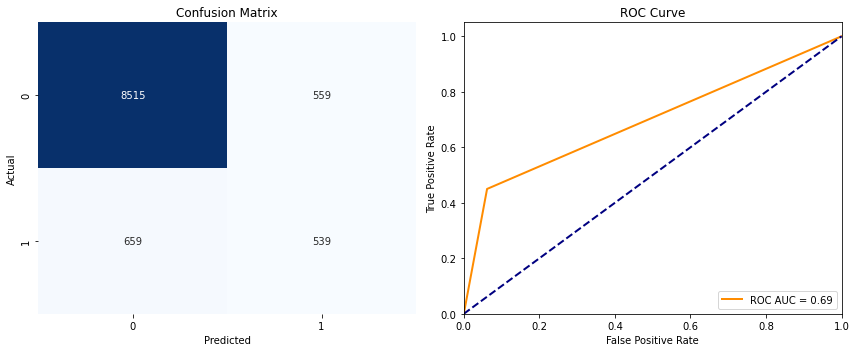

In [41]:
# Now let us see how Optimized SVM did 

# Make predictions on the test data
y_pred = best_svc.predict(X_test)

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)

# Compute ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots for confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [42]:
# Generate a classification report 
classification_rep = classification_report(y_test, y_pred, zero_division=1)

# Print the classification report without the warning
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      9074
           1       0.49      0.45      0.47      1198

    accuracy                           0.88     10272
   macro avg       0.71      0.69      0.70     10272
weighted avg       0.88      0.88      0.88     10272



### Observations:
- Optimizeation (Grid search) run a very long time: over 4 hours
- Class 1 Recall (primary metric) increased to 0.45
- Overall Accuracy dropped to 0.88
- ROC AUC increase slightly to 0.69


# Findings and Conclusions

1. Business Understanding is necessary to arrive at the most appropriate Success Metric. In this case, I believe that Class 1 Recall would be the most important metric for the client. This is because the good prospects are both very valuable (they subscribe to highly profitable long-term deposits) and highly rare (only 12% are "good" prospects). 
2. Data Preparation is key to building successful models. Cleaning up the data by removing features that can cause Multicollinearity and also handling the outliners is important for many of the classification models that I used at this time. 
3. SVM was the slowest model because of the very large data set. 
4. The best-performing model for this data set was the Decision Tree. 
    - It produced the best Class 1 Recall metric, the most important metric in our case.  
    - ROC AUC was also the best (0.72) for this model. 
    - The Decision Tree was a relatively fast model, too. The basic model with default parameters took only 0.12 seconds to train. A grid search with as many as 5950 folds took only 2 minutes and 3 seconds to complete. Only Logistic Regression was faster, but it didn't perform as well. 
     - Based on this metric, I recommend the client use the Decision Tree. Decision Trees are also easy to interpret, which is another advantage. 
     - In the future, I'd like to experiment with ensemble tree models, which are based on trees (or tiny trees). These include: 
            - Random Forest
            - Gradient Boosting Machines (GBM), such as XGBoost, LightGBM, and CatBoost.
            - AdaBoost (Adaptive Boosting)
            - Extra Trees (Extremely Randomized Trees)

